# HW1: Moving Least Squares (MLS)

In this exercise you will:

* Compute an implicit MLS function that approximates a cloud of 2D/3D points with normals. The input points will then lie at the zero level set of the computed function.

* Sample the implicit function on a three dimensional volumetric grid.

* Reconstruct a triangle mesh / contours of the zero level set of the implicit function, by using the Marching Cubes/Squares algorithm on the grid.

* Experiment with various MLS reconstruction parameters.

\
__Grading__:\
There are 4 graded tasks:
* Constraints sampling - 5%
* Global model - 5%
* Local model - 5%
* (Bonus) All the same but in 3D (see bonus.ipynb) - 5%

__Note__ that it's possible to write (almost) all the functions compatible with 2D and 3D data (without "if" branches), but not required. So if you don't do the bonus task, you can assume that all data is in 2D

In [1]:
#enable plugin to automatically reload the module when a method is called
%reload_ext autoreload 
%autoreload 2
import numpy as np
import polyscope as ps
from utils import read_off, to_np, bounding_box_diag
import matplotlib.pyplot as plt

## Part 0: Data

In [2]:
from data.lines_generator_2D import sample_cirlce 
from utils import plot_arrow

Let's generate a set of points that lay on a circle. We'll also need normal for each of the points

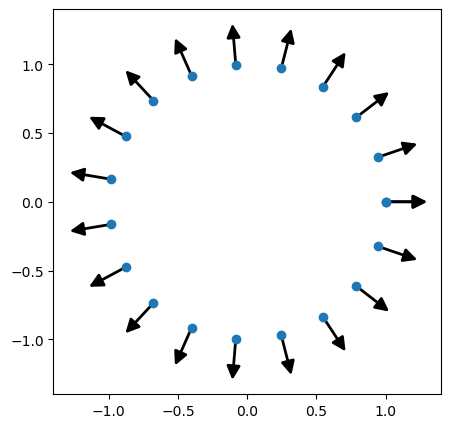

In [3]:
vertices, normals = sample_cirlce(1, 20)

plt.figure(figsize=(5,5))
plt.scatter(vertices[:,0], vertices[:,1])
for vert, norm in zip(vertices, normals):
    plot_arrow(begin=vert, end=vert+norm*0.3)
plt.gca().set_xlim(-1.4, +1.4)
plt.gca().set_ylim(-1.4, +1.4)
plt.show()

## Part 1: setting up constraints

The task of this assignment is to come up with an implicit function $f(p), p = (x,y)$ defined on all of the 2D space, such that the input point cloud lies at the zero level set of this function, i.e. for any point pi in the input point cloud, we have $f(p_i) = 0$. The normals of the implicit function evaluated at the point cloud locations should agree with the normals of the point cloud (also provided as input).

The implicit function is typically interpolated from a set of given values at given points. Given the
function values $f_i$ at some given points $p_i$ (the constrained points), the function $f$ is found by solving
a minimization of the form

$$f = \arg \min_{\phi} \sum_{i} ||\phi(p_i) - f_i || $$

where $\phi(p)$ is any acceptable function (such as any function computed via an MLS procedure). 
The first step is thus specifying those constraints. Naturally, the input point cloud should be part of the constraints, with the value of $f = 0$.
However, if the constraints only lie on the zero level set, most interpolation schemes will only generate the zero function as a result. We thus need to introduce more constraints. 
The process for generating the constraints is as follows:

• For all point cloud points $p_i$ we know the constraint $f(p_i)$ = 0.

• Fix an ε value, for instance $ε = 0.01 ×$ bounding box diagonal.

• For each point $p_i$ compute $\hat{p_{i}} = p_i + εn_i$, where $n_i$ is the normalized normal of $p_i$. Check
whether $\hat{p_i}$ is the closest point to $p_i$ ; if not, divide ε by 2 and recompute $\hat{p_i}$ until this is
the case. Then, add another constraint equation: $f (\hat{p_i} ) = ε$.

• Repeat the same process for −ε, i.e., add equations of the form $f(p^*_i) = −ε$. Dont forget
to check that $p^*_i$ is the closest point to p_i .

As a result of the steps, for the N point cloud points you get 3N equations for the
implicit function $f(x,y)$.

__Task 1__: 

Please implement `sample_constraints(...)` in `task1_constraints.py`

Once it is done, we can visualize the result:

In [4]:
from task1_constraints import sample_constraints
from tests import check_constraints

bbox_diag = bounding_box_diag(vertices)
eps = bbox_diag * 0.1
new_verts, new_vals = sample_constraints(vertices, normals, eps)

constr_pts = np.concatenate([vertices, new_verts])
constr_vals = np.concatenate([np.zeros(len(vertices)), new_vals])

# check_constraints(vertices, normals, constr_pts, constr_vals)

(40, 2) (40,)


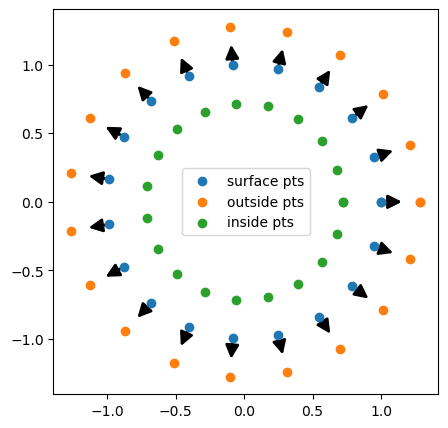

In [5]:
def show_constraint_points(pts, vals):
    plt.scatter(pts[vals==0][:,0], pts[vals==0][:,1], label='surface pts')
    plt.scatter(pts[vals>0][:,0], pts[vals>0][:,1], label='outside pts')
    plt.scatter(pts[vals<0][:,0], pts[vals<0][:,1], label='inside pts')
    plt.legend()
    plt.axis('square')

plt.figure(figsize=(5,5))
show_constraint_points(constr_pts, constr_vals)
for vert, norm in zip(vertices, normals):
    plot_arrow(begin=vert, end=vert+norm*0.15)

## Part 2: MLS Interpolation

Given the constraints, you can use interpolation to construct the implicit function. The function is not defined explicitly e.g. by a formula; instead it can be evaluated at any given point in 2D space. At any point, the function is computed as a weighted sum of polynomial functions defined on the constrained points, where the weights vary from one points to the other (MLS).

More specifically:

2.1 First, define a grid in space that contains the constraint points from part 1. The resolution of the grid - is a parameter to be adjusted in experiments. (it's already implemented for you)

2.2 For each node of the grid compute the value of the implicit function f(x,y) whose zero level set approximates the point cloud. Use the moving least squares approximation

* For each grid node find closest constraint vertices within a fixed radius. Check if the number of them is sufficient to build a polynomial of chosen degree 

* Find parameters of a polynomial that approximates the values of the constraint vertices
    
* Evaluate the polynomial at the grid node.


#### 2.1 Grid Generation

In [6]:
from task2_solver import generate_grid

resolution = 20
grid_pts, coords_matrix = generate_grid(constr_pts, resolution, num_dims=2)

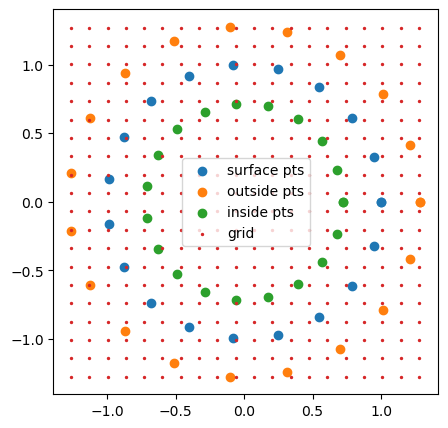

In [7]:
plt.figure(figsize=(5,5))
show_constraint_points(constr_pts, constr_vals)
plt.scatter(grid_pts[:,0], grid_pts[:,1], s=2, label='grid')
plt.legend()
plt.axis('square')
plt.show()

#### 2.2 Setting up predictor

 __Task 2__: 
 Please implement the missing part of `global_predictor(...)` function in `task2_solver.py`. 
 - First, convert grid and constraint points into required polynomial basis (degree). You may use transform_to_polynomial_basis function for this 
 - Then solve linear least squares problem: 
$X$ (matrix) - constraint point in polynomial basis (constr_pts) \
\
 $x$ (vector) - constraint point in polynomial basis (constr_pts[i]) \
 $ v$ (vector) - the implicit function values in constraints points (constr_vals[i]) \
 $ c$ (vector) - coefficients of the polynomial (that approximates the shape)\
 \
 Optimizations problem:\
 $X \cdot c = v$\
 $c = \text{argmin}_{c}  \sum_i  ||v_i - x_i \cdot c||_2^2 $
 \
 $ c = ...$ - use analytical solution described in class (linear least squares)

 * Finally, interpolate implicit function in the grid points, e.g.:\
$ g$ - a grid point (grid_pts[i])\
$\hat v$ - the predicted value at the grid point\
$\hat v =  g \cdot c$
 

In [8]:
from task2_solver import global_predictor
pred_vals = global_predictor(grid_pts, constr_pts, constr_vals, degree=2)

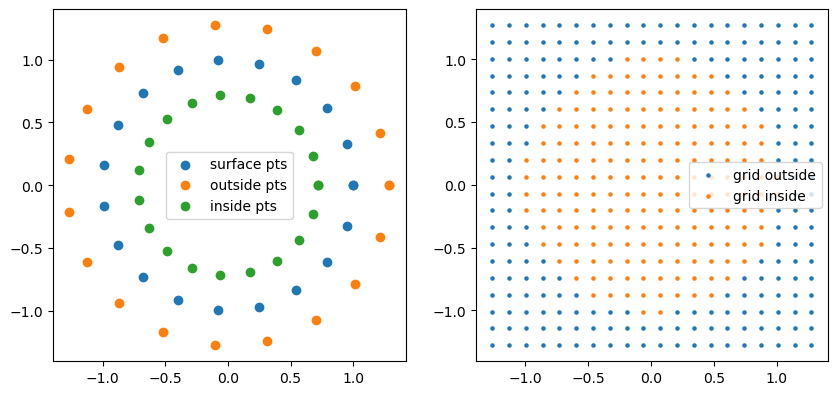

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(121)
show_constraint_points(constr_pts, constr_vals)

def show_grid_pts(grid_pts, grid_vals):
    plt.scatter(grid_pts[grid_vals>=0][:,0], grid_pts[grid_vals>=0][:,1], s=5, label='grid outside')
    plt.scatter(grid_pts[grid_vals<0][:,0], grid_pts[grid_vals<0][:,1], s=5, label='grid inside')
    plt.legend()
    plt.axis('square')

plt.subplot(122)
show_grid_pts(grid_pts, pred_vals)

plt.show()

## Part 3: Final reconstruction

You can now use marching squares to extract the zero isosurface from your grid. This part has been done for you.

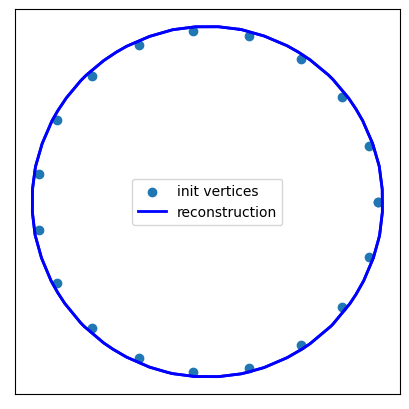

In [10]:
from skimage import measure

def transform_pts(pts, matr):
    return (matr[:2, :2] @ pts.T + matr[:2, 2:3]).T

def reconstruct(pred_vals, resolution):
    return measure.find_contours(pred_vals.reshape(resolution, resolution), 0)

def show_reconstruction(pred_vals, resolution, transform_matrix):
    contours = reconstruct(pred_vals, resolution)

    ax = plt.gca()
    ax.scatter(vertices[:,0], vertices[:,1], label='init vertices')
 
    for contour in contours:
        contour = transform_pts(contour, transform_matrix)
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='b')
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='b', label='reconstruction')

    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.legend()
    plt.axis('square')

plt.figure(figsize=(5,5))
show_reconstruction(pred_vals, resolution, coords_matrix)

## Part 4: Local model

Okay, now lets see if the models works on a bit more complicated:

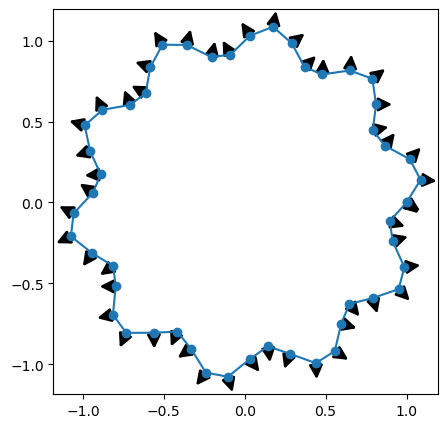

In [11]:
from data.lines_generator_2D import sample_curved_cirlce

vertices, normals = sample_curved_cirlce(1, 50)

plt.figure(figsize=(5,5))
plt.plot(vertices[:,0], vertices[:,1])
plt.scatter(vertices[:,0], vertices[:,1])

for vert, norm in zip(vertices, normals):
    plot_arrow(begin=vert, end=vert+norm*0.1)
plt.axis('square')
plt.show()

Sampling the constraint points the same as before

(100, 2) (100,)


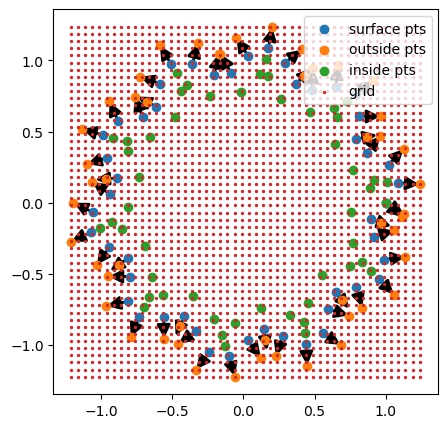

In [12]:
bbox_diag = bounding_box_diag(vertices)
eps = bbox_diag * 0.05
new_verts, new_vals = sample_constraints(vertices, normals, eps)

constr_pts = np.concatenate([vertices, new_verts])
constr_vals = np.concatenate([np.zeros(len(vertices)), new_vals])

check_constraints(vertices, normals, constr_pts, constr_vals)

resolution = 50
grid_pts, coords_matrix = generate_grid(constr_pts, resolution, num_dims=2)

plt.figure(figsize=(5,5))
show_constraint_points(constr_pts, constr_vals)
for vert, norm in zip(vertices, normals):
    plot_arrow(begin=vert, end=vert+norm*0.15)
plt.scatter(grid_pts[:,0], grid_pts[:,1], s=2, label='grid')
plt.legend()
plt.axis('square')
plt.show()

Use the same global predictor as before

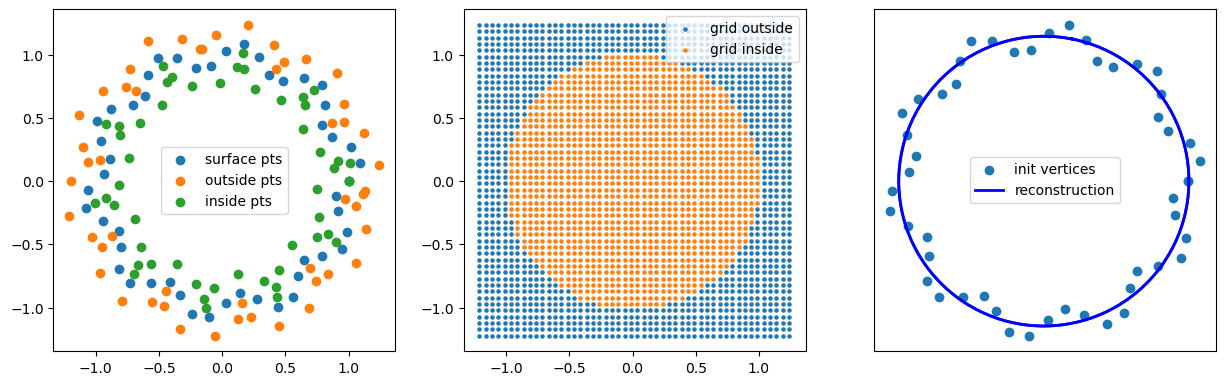

In [13]:
pred_vals = global_predictor(grid_pts, constr_pts, constr_vals, degree=2)

plt.subplots(1, 3, figsize=(15,5))
plt.subplot(131); show_constraint_points(constr_pts, constr_vals)
plt.subplot(132); show_grid_pts(grid_pts, pred_vals)
plt.subplot(133); show_reconstruction(pred_vals, resolution, coords_matrix)
plt.show()

As you can see the model is not strong enough to approximate the data. \
Instead of increasing the complexity of the model (the degree of polynomial) we can build many local polynomial approximators.\
So the algorithm is following:

- For each grid node find closest (in a fixed radius) constraint points.
- Check if the number of them is sufficient to build a polynomial of chosen degree.

__Task 3.1__: \
Please implement part of  `local_predictor(...)` in `task2_solver.py`. You need to find nearest neighbours in a fixed radius

- Given a grid point, it's nearest constrain points and constraint values, build polynomial (of specified degree) that approximates the constraint points in the local space: \
\
 $ g$ - grid point in polynomial basis (grid_pts[i])\
 $ N_X(g)$ - nearest constraint points in the neighbourhood of grid point $g$  \
 $ x_i$ (vector) - constraint point in polynomial basis (constr_pts[i]) \
 $ v_i$ (vector) - the implicit function values in constraints points (constr_vals[i]) \
 $ c$ (vector) - coefficients of the polynomial (that approximates the shape)\
 \
 Note that we'll build __weighted__ least squares. This means that error at each of the constraint points will be weighted. The weight is the wendland function (is implemented in `task2_solver.py`). The smaller the distance between the grid and the constraint point is the bigger is the weight term for this point\
 $w_i$ (scalar) - the weight of the constraint point. $w_i$ = wendland(distance($g$, $x_i$))
 \
 \
The optimization problem for each grid point is:

$$c = \text{argmin}_{c}  \sum_{x_i \in N_X(g)}  w_i * ||v_i - x_i \cdot c||_2^2 $$ 

 $$ c = ... \text{- use analytical solution described in class (weighted linear least squares)}$$

 * Finally, interpolate implicit function in the grid points, e.g.:\
$\hat v$ - the predicted value at the grid point $g$\
$\hat v =  g \cdot c$

__Task 3.2__: \
Please implement part of  `eval_grid_point(...)` in `task2_solver.py`. 

In [14]:
from task2_solver import local_predictor

local_radius = bbox_diag * 0.2
pred_vals = local_predictor(grid_pts, constr_pts, constr_vals, local_radius, degree=2)

plt.subplots(1, 3, figsize=(15,5))
plt.subplot(131); show_constraint_points(constr_pts, constr_vals)
plt.subplot(132); show_grid_pts(grid_pts, pred_vals)
plt.subplot(133); show_reconstruction(pred_vals, resolution, coords_matrix)
plt.show()

(2,)
(6, 2)
(6,)


AttributeError: 'list' object has no attribute 'shape'

The model approximates the data, but has some noise. Let's regularize the model:

$$c = \text{argmin}_{c}  \sum_{x_i \in N_X(g)}  w_i * ||v_i - x_i \cdot c||_2^2  + |c|_2^2$$

In [ ]:
from task2_solver import local_predictor

local_radius = bbox_diag * 0.2
pred_vals = local_predictor(grid_pts, constr_pts, constr_vals, local_radius, degree=2, reg_coef=0.001)

plt.subplots(1, 3, figsize=(15,5))
plt.subplot(131); show_constraint_points(constr_pts, constr_vals)
plt.subplot(132); show_grid_pts(grid_pts, pred_vals)
plt.subplot(133); show_reconstruction(pred_vals, resolution, coords_matrix)
plt.show()

We will not address the "floater" in the middle of the plot; it happens because the middle points are too far from the constraints.
The easiest way to fix it is to discard connected components whose average distance from the data is larger than some threshold.